In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_dir = "/Users/keturner/ENOI/calculate_drifts/drifts_regridded"
output_dir = "/Users/keturner/ENOI/calculate_drifts/drifts_integrated"

model = ["ACCESS"]#, "CanESM", "CESM", "IPSL", "MPI", "NorESM", "UKESM"]
var = ["dissic"]#, "so", "thetao"]
dz_list = [100, 500, 1000, 2000]

In [3]:
for dz in dz_list:
    for v in var:
        for m in model:
            ds = xr.open_dataset(f"{input_dir}/drift_100yr_{v}_{m}_1x1.nc")
    
            # pull out depth bounds 
            levbnds = ds.lev_bnds.data

            thickness = np.diff(levbnds, axis=1).squeeze()
            total_z = np.cumsum(thickness)
            idx_depth = np.where(total_z <= dz)[0][-1]
            idx_depth

            weights = np.zeros(np.size(levbnds,0))
            if total_z[idx_depth] == dz: # no partial cells needed
                weights[:idx_depth+1] = thickness[:idx_depth+1]
            elif total_z[idx_depth] < dz: # partial cell needed to get to depth horizon
                weights[:idx_depth+1] = thickness[:idx_depth+1]
                weights[idx_depth+1] = dz - total_z[idx_depth]

            weights = xr.DataArray(weights, 
                coords={'lev': ds.lev}, 
                dims=["lev"])

            drift_weighted = ds.drift_100yr_gr.weighted(weights)
            drift_int = drift_weighted.sum(dim='lev')
    
            ds_out = drift_int.to_dataset(name = f"drift_{v}_{m}_{dz}int")
            ds_out.to_netcdf(f"{output_dir}/drift_{v}_{m}_{dz:04d}int.nc")

In [5]:
ds1 = xr.open_dataset(f"{output_dir}/drift_{v}_{m}_0100int.nc")
ds2 = xr.open_dataset(f"{output_dir}/drift_{v}_{m}_0500int.nc")
ds3 = xr.open_dataset(f"{output_dir}/drift_{v}_{m}_1000int.nc")
ds4 = xr.open_dataset(f"{output_dir}/drift_{v}_{m}_2000int.nc")

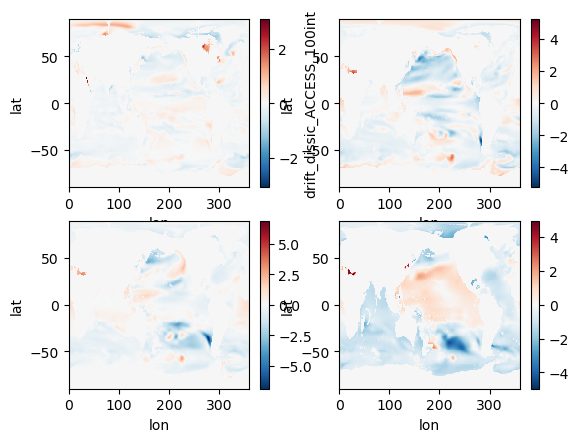

In [7]:
fig, axs = plt.subplots(2,2)
axs = axs.flatten()

ds1.drift_dissic_ACCESS_100int.plot(ax= axs[0])
(ds2.drift_dissic_ACCESS_500int - ds1.drift_dissic_ACCESS_100int).plot(ax= axs[1])
(ds3.drift_dissic_ACCESS_1000int - ds2.drift_dissic_ACCESS_500int).plot(ax= axs[2])
(ds4.drift_dissic_ACCESS_2000int - ds3.drift_dissic_ACCESS_1000int).plot(ax= axs[3])